# Homework 3: Building an NDArray library

In this homework, you will build a simple backing library for the processing that underlies most deep learning systems: the n-dimensional array (a.k.a. the NDArray).  Up until now, you have largely been using numpy for this purpose, but this homework will walk you through developing what amounts to your own (albeit much more limited) variant of numpy, which will support both CPU and GPU backends.  What's more, unlike numpy (and even variants like PyTorch), you won't simply call out to existing highly-optimized variants of matrix multiplication or other manipulation code, but actually write your own versions that are reasonably competitive will the highly optimized code backing these standard libraries (by some measure, i.e., "only 2-3x slower" ... which is a whole lot better than naive code that can easily be 100x slower).  This class will ultimately be integrated into `needle`, but for this assignment you can _only_ focus on the ndarray module, as this will be the only subject of the tests.

**Note**: To avoid exhausting limited GPU resources in Colab, start by using CPU runtime for coding and testing non-GPU functions. Switch to GPU runtime when testing CUDA or GPU-accelerated code. This approach ensures efficient GPU usage and prevents running out of resources during critical tasks.

In [1]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
!git clone https://github.com/dlsys10714/hw3.git
%cd /content/drive/MyDrive/10714/hw3

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pybind11
!pip3 install triton

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/10714
fatal: destination path 'hw3' already exists and is not an empty directory.
/content/drive/MyDrive/10714/hw3
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-cjx0lq06
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-cjx0lq06
  Resolved https://github.com/dlsys10714/mugrade.git to commit 656cdc2b7ad5a37e7a5347a7b0405df0acd72380
  Preparing metadata (setup.py) ... done
  Created wheel for mugrade: filename=mugrade-1.2-py3-none-any.whl size=3935 sha256=c05fd3ae32d05e96f3723a6f0cfb2e24b8e7024a0a8eb6eebed5ffc30fa29214
  Stored in directory: /tmp/pip-ephem-wheel-cache-q8i1xotc/wheels/8b/ba/3a/621da1207eab160c01968c5e0bd1266f505b9e3f8010376d61
Successfully built mugrade
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.8 MB/s eta 0:00:0

In [2]:
!make

-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.13.6")
-- Found cuda, building cuda backend
Tue Dec 10 05:34:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                   

The make command reads the Makefile in the current directory. The Makefile contains rules that define how to build targets (like executables or libraries). For each target specified in the Makefile, make checks the timestamps of the target file and its dependencies (like .c, .cpp, or .h files). If any dependency has been modified recently, it must rebuild the target.

In [3]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [4]:
import sys
sys.path.append('./python')

# Benchmarking the performance our implementations in CPU, CUDA, Triton

Here we benchmark our implementations for our course project. We compare TFLOPS (the larger the better) for the following implementations:

1. CPU
2. CUDA (our implementation)
3. Triton

We benchmark the performance for the following operations:

1. Matmul

In [15]:
import triton
import numpy as np
from needle import backend_ndarray as nd


MATMUL_BENCHMARK_CONFIGS = [
  triton.testing.Benchmark(
    x_names=["M", "N", "K"],
    x_vals=[2 ** i for i in range(1, 13)],
    line_arg="device",
    line_vals = [nd.cpu(), nd.cuda(), nd.triton()],
    line_names = ["cpu", "cuda", "triton"],
    styles=[("green", "-"), ("blue", "-"), ("red", "-")],
    ylabel="TFLOPS",
    xlabel="Number of Rows",
    plot_name="matmul-performance-matmul",
    args={},
  )
]


@triton.testing.perf_report(MATMUL_BENCHMARK_CONFIGS)
def benchmark_matmul_operation(M, N, K, device):
    _A = np.random.randn(M, N)
    _B = np.random.randn(N, K)

    A = nd.array(_A, device=device)
    B = nd.array(_B, device=device)

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: A @ B, quantiles=quantiles)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

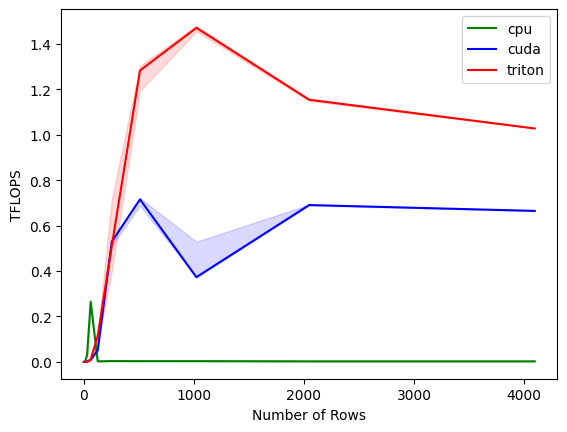

In [16]:
benchmark_matmul_operation.run(show_plots=True)

Above is our benchmarking operation for the Matmul operation.

## Getting familiar with the NDArray class

As you get started with this homework, you should first familiarize yourself with the `NDArray.py` class we have provided as a starting point for the assignment.  The code is fairly brief (it's ~500 lines, but a lot of these are comments provided for the functions you'll implement).

At its core, the NDArray class is a Python wrapper for handling operations on generic n-dimensional arrays.  Recall that virtually any such array will be stored internally as a vector of floating point values, i.e.,

```c++
float data[size];
```

and then the actual access to different dimensions of the array are all handled by additional fields (such as the array shape, strides, etc) that indicates how this "flat" array maps to n-dimensional structure.  In order to achieve any sort of reasonable speed, the "raw" operations (like adding, binary operations, but also more structured operations like matrix multiplication, etc), all need to be written at some level in some native language like C++ (including e.g., making CUDA calls).  But a large number of operations likes transposing, broadcasting, sub-setting of matrices, and other, can all be handled by just adjusting the high-level structure of the array, like it's strides.

The philosophy behind the NDArray class is that we want _all_ the logic for handling this structure of the array to be written in Python.  Only the "true" low level code that actually performs the raw underlying operations on the flat vector (as well as the code to manage these flat vectors, as they might need to e.g., be allocated on GPUs), is written in C++.  The precise nature of this separation will likely start to make more sense to you as you work through the assignment, but generally speaking everything that can be done in Python, is done in Python; often e.g., at the cost of some inefficiencies ... we call `.compact()` (which copies memory) liberally in order to make the underlying C++ implementations simpler.

In more detail, there are five fields within the NDArray class that you'll need to be familiar with (note that the real class member these all these fields is preceded by an underscore, e.g., `_handle`, `_strides`, etc, some of which are then exposed as a public property ... for all your code it's fine to use the internal, underscored version).

1. `device` - A object of type `BackendDevice`, which is a simple wrapper that contains a link to the underlying device backend (e.g., CPU or CUDA).
2. `handle` - A class objected that stores the underlying memory of the array.  This is allocated as a class of type `device.Array()`, though this allocation all happens in the provided code (specifically the `NDArray.make` function), and you don't need to worry about calling it yourself.
3. `shape` - A tuple specifying the size of each dimension in the array.
4. `strides` - A tuple specifying the strides of each dimension in the array.
5. `offset` - An integer indicating where in the underlying `device.Array` memory the array actually starts (it's convenient to store this so we can more easily manage pointing back to existing memory, without having to track allocations).

By manipulating these fields, even pure Python code can perform a lot of the needed operations on the array, such as permuting the dimensions (i.e., transposing), broadcasting, and more.  And then for the raw array manipulation calls, the `device` class has a number of methods (implemented in C++) that contains the necessary implementations.

There are a few points to note:

* Internally, the class can use _any_ efficient means of operating on arrays of data as a "device" backend.  Even, for example, a numpy array, but where instead of actually using the `numpy.ndarray` to represent the n-dimensional array, we just represent a "flat" 1D array in numpy, then call the relevant numpy methods to implement all the needed operators on this raw memory.  This is precisely what we do in the `ndarray_backend_numpy.py` file, which essentially provided a "stub reference" that just uses numpy for everything.  You can use this class to help you  better debug your own "real" implementations for the "native" CPU and GPU backends.
* Of particular importance for many of your Python implementations will be the `NDArray.make` call:
```python
def make(shape, strides=None, device=None, handle=None, offset=0):
```
which creates a new NDArray with the given shape, strides, device, handle, and offset.  If `handle` is not specified (i.e., no pre-existing memory is referenced), then the call will allocate the needed memory, but if handle _is_ specified then no new memory is allocated, but the new NDArray points the same memory as the old one.  It is important to efficient implementations that as many of your functions as possible _don't_ allocate new memory, so you will want to use this call in many cases to accomplish this.
* The NDArray has a `.numpy()` call that converts the array to numpy.  This is _not_ the same as the "numpy_device" backend: this creates an actual `numpy.ndarray` that is equivalent to the given NDArray, i.e., the same dimensions, shape, etc, though not necessarily the same strides (Pybind11 will reallocate memory for matrices that are returned in this manner, which can change the striding).


## Part 1: Python array operations

As a starting point for your class, implement the following functions in the `ndarray.py` file:

- `reshape()`
- `permute()`
- `broadcast_to()`
- `__getitem__()`

The inputs/outputs of these functions are all described in the docstring of the function stub.  It's important to emphasize that _none_ of these functions should reallocate memory, but should instead return NDArrays that share the same memory with `self`, and just use clever manipulation of shape/strides/etc in order to obtain the necessary transformations.

To get started you can refer to the hints mentioned in the class slides for transpose, broadcast and slicing operator.

One thing to note is that the `__getitem__()` call, unlike numpy, will never change the number of dimensions in the array.  So e.g., for a 2D NDArray `A`, `A[2,2]` would return a still-2D with one row and one column.  And e.g. `A[:4,2]` would return a 2D NDarray with 4 rows and 1 column.

You can rely on the `ndarray_backend_numpy.py` module for all the code in this section.  You can also look at the results of equivalent numpy operations (the test cases should illustrate what these are).

After implementing these functions, you should pass/submit the following tests.  Note that we test all of these four functions within the test below, and you can incrementally try to pass more tests as you implement each additional function.

In [17]:
!python3 -m pytest -v -k "(permute or reshape or broadcast or getitem) and cpu and not compact"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_permute[cpu-params0] PASSED                                  [ 10%]
tests/hw3/test_ndarray.py::test_permute[cpu-params1] PASSED                                  [ 20%]
tests/hw3/test_ndarray.py::test_permute[cpu-params2] PASSED                                  [ 30%]
tests/hw3/test_ndarray.py::test_reshape[cpu-params0] PASSED                                  [ 40%]
tests/hw3/test_ndarray.py::test_reshape[cpu-params1] PASSED                                  [ 50%]
tests/hw3/test_ndarray.py::test_getitem[cpu-params0] PASSED                                  [ 60%]
tests/hw3/tes

In [18]:
!python3 -m pytest -v -k "(permute or reshape or broadcast or getitem) and cuda and not compact"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_permute[cuda-params0] PASSED                                 [ 10%]
tests/hw3/test_ndarray.py::test_permute[cuda-params1] PASSED                                 [ 20%]
tests/hw3/test_ndarray.py::test_permute[cuda-params2] PASSED                                 [ 30%]
tests/hw3/test_ndarray.py::test_reshape[cuda-params0] PASSED                                 [ 40%]
tests/hw3/test_ndarray.py::test_reshape[cuda-params1] PASSED                                 [ 50%]
tests/hw3/test_ndarray.py::test_getitem[cuda-params0] PASSED                                 [ 60%]
tests/hw3/tes

In [19]:
!python3 -m pytest -v -k "(permute or reshape or broadcast or getitem) and triton and not compact"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_permute[triton-params0] PASSED                               [ 10%]
tests/hw3/test_ndarray.py::test_permute[triton-params1] PASSED                               [ 20%]
tests/hw3/test_ndarray.py::test_permute[triton-params2] PASSED                               [ 30%]
tests/hw3/test_ndarray.py::test_reshape[triton-params0] PASSED                               [ 40%]
tests/hw3/test_ndarray.py::test_reshape[triton-params1] PASSED                               [ 50%]
tests/hw3/test_ndarray.py::test_getitem[triton-params0] PASSED                               [ 60%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_python_ops"

## Part 2: CPU Backend - Compact and setitem

Implement the following functions in `ndarray_backend_cpu.cc`:
* `Compact()`
* `EwiseSetitem()`
* `ScalarSetitem()`

To see why these are all in the same category, let's consider the implementation of the `Compact()` function.  Recall that a matrix is considered compact if it is layed out sequentially in memory in "row-major" form (but really a generalization of row-many to higher dimensional arrays), i.e. with the last dimension first, followed by the second to last dimension, etc, all the way to the first.  In our implementation, we also require that the total size of allocated backend array be equal to the size of the array (i.e., the underlying array also can't have any data before or after the array data, which e.g., implies that the `.offset` field equals zero).

Now let's consider, using a 3D array as a an example, of how a compact call might work.  Here `shape` and `strides` are the shape and strides of the matrix being compacted (i.e., before we have compacted it).

```c++
cnt = 0;
for (size_t i = 0; i < shape[0]; i++)
    for (size_t j = 0; j < shape[1]; j++)
        for (size_t k = 0; k < shape[2]; k++)
            out[cnt++] = in[strides[0]*i + strides[1]*j + strides[2]*k];
```
In other words, we're converting from a stride-based representation of the matrix to a purely sequential one.

Now, the challenge in implementing `Compact()` is that you want the method to work for any number of input dimensions.  It's easy to specialize for different fixed-dimension-size arrays, but for a generic implementation, you'll want to think about how to do this same operation where you effectively want a "variable number of for loops".  As a hint, one way to do this is to maintain a vector of indices (of size equal to the number of dimensions), and then manually increment them in a loop (including a "carry" operation when any of the reaches their maximum size).

However, if you get really stuck with this, you can alway use the fact that we're probably not going to ask you to deal with matrices of more than 6 dimensions (though we _will_ use 6 dimensions, for the im2col operation we discussed in class).


#### The connection to setitem
The setitem functionality, while seemingly quite different, is actually intimately related to `Compact()`.  `__setitem()__` is the Python function called when setting some elements of the object, i.e.,
```python
A[::2,4:5,9] = 0 # or = some_other_array
```
How would you go about implementing this?  In the `__getitem()__` call above, you already implemented a method to take a subset of a matrix without copying (but just modifying strides).  But how would you actually go about _setting_ elements of this array?  In virtually all the other settings in this homework, we call `.compact()` before setting items in an output array, but in this case it doesn't work: calling `.compact()` would copy the subset array to some new memory, but the whole point of the `__setitem__()` call is that we want to modify existing memory.

If you think about this for a while, you'll realize that the answer looks a lot like `.compact()` but in reverse.  If we want to assign a (itself already compact) right hand side matrix to a `__getitem()__` results, then we need to here like `shape` and `stride` be those fields of the _output_ matrix.  Then we could implement the setitem call as follows

```c++
cnt = 0;
for (size_t i = 0; i < shape[0]; i++)
    for (size_t j = 0; j < shape[1]; j++)
        for (size_t k = 0; k < shape[2]; k++)
            out[strides[0]*i + strides[1]*j + strides[2]*k] = in[cnt++]; // or "= val;"
```
Due to this similarity, if you implement your indexing strategy in a modular fashion, you'll be able to reuse it between the `Compact()` call and the `EwiseSetitem()` and `ScalarSetitem()` calls.

**Note**: Don't forget to run make before executing the tests to rebuild your modified C++ code.

In [ ]:
!python3 -m pytest -v -k "(compact or setitem) and cpu"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 187 deselected / 15 selected                                                 

tests/hw3/test_ndarray.py::test_compact[cpu-transpose] PASSED                                [  6%]
tests/hw3/test_ndarray.py::test_compact[cpu-broadcast_to] PASSED                             [ 13%]
tests/hw3/test_ndarray.py::test_compact[cpu-reshape1] PASSED                                 [ 20%]
tests/hw3/test_ndarray.py::test_compact[cpu-reshape2] PASSED                                 [ 26%]
tests/hw3/test_ndarray.py::test_compact[cpu-reshape3] PASSED                                 [ 33%]
tests/hw3/test_ndarray.py::test_compact[cpu-getitem1] PASSED                                 [ 40%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "(compact or setitem) and cuda"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 187 deselected / 15 selected                                                 

tests/hw3/test_ndarray.py::test_compact[cuda-transpose] PASSED                               [  6%]
tests/hw3/test_ndarray.py::test_compact[cuda-broadcast_to] PASSED                            [ 13%]
tests/hw3/test_ndarray.py::test_compact[cuda-reshape1] PASSED                                [ 20%]
tests/hw3/test_ndarray.py::test_compact[cuda-reshape2] PASSED                                [ 26%]
tests/hw3/test_ndarray.py::test_compact[cuda-reshape3] PASSED                                [ 33%]
tests/hw3/test_ndarray.py::test_compact[cuda-getitem1] PASSED                                [ 40%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "(compact or setitem) and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 187 deselected / 15 selected                                                 

tests/hw3/test_ndarray.py::test_compact[triton-transpose] PASSED                             [  6%]
tests/hw3/test_ndarray.py::test_compact[triton-broadcast_to] PASSED                          [ 13%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape1] PASSED                              [ 20%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape2] PASSED                              [ 26%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape3] PASSED                              [ 33%]
tests/hw3/test_ndarray.py::test_compact[triton-getitem1] PASSED                              [ 40%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cpu_compact_setitem"

## Part 3: CPU Backend - Elementwise and scalar operations

Implement the following functions in `ndarray_backend_cpu.cc`:

* `EwiseMul()`, `ScalarMul()`
* `EwiseDiv()`, `ScalarDiv()`
* `ScalarPower()`
* `EwiseMaximum()`, `ScalarMaximum()`
* `EwiseEq()`, `ScalarEq()`
* `EwiseGe()`, `ScalarGe()`
* `EwiseLog()`
* `EwiseExp()`
* `EwiseTanh()`

You can look at the included
`EwiseAdd()` and `ScalarAdd()` functions (plus the invocations from `NDArray` in order to understand the required format of these functions.

Note that unlike the remaining functions mentioned here, we do not include function stubs for each of these functions.  This is because, while you can implement these naively just through implementing each function separately, though this will end up with a lot of duplicated code.  You're welcome to use e.g., C++ templates or macros to address this problem (but these would only be exposed internally, not to the external interface).

**Note**: Remember to register functions  in the pybind module after finishing your implementations.

In [ ]:
!python3 -m pytest -v -k "(ewise_fn or ewise_max or log or exp or tanh or (scalar and not setitem)) and cpu"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 179 deselected / 23 selected                                                 

tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-multiply] PASSED                         [  4%]
tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-divide] PASSED                           [  8%]
tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-add] PASSED                              [ 13%]
tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-subtract] PASSED                         [ 17%]
tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-equal] PASSED                            [ 21%]
tests/hw3/test_ndarray.py::test_ewise_fn[cpu-shape0-greater_than] PASSED                     [ 26%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "(ewise_fn or ewise_max or log or exp or tanh or (scalar and not setitem)) and cuda"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 179 deselected / 23 selected                                                 

tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-multiply] PASSED                        [  4%]
tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-divide] PASSED                          [  8%]
tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-add] PASSED                             [ 13%]
tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-subtract] PASSED                        [ 17%]
tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-equal] PASSED                           [ 21%]
tests/hw3/test_ndarray.py::test_ewise_fn[cuda-shape0-greater_than] PASSED                    [ 26%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "(ewise_fn or ewise_max or log or exp or tanh or (scalar and not setitem)) and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 179 deselected / 23 selected                                                 

tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-multiply] PASSED                      [  4%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-divide] PASSED                        [  8%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-add] PASSED                           [ 13%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-subtract] PASSED                      [ 17%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-equal] PASSED                         [ 21%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-greater_than] PASSED                  [ 26%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cpu_ops"

submit
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.3.0
collected 9 items / 8 deselected / 1 selected                                                      

tests/hw3/test_ndarray.py 
Submitting ndarray_cpu_ops...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
.

================================= 1 passed, 8 deselected in 7.71s ==================================


## Part 4: CPU Backend - Reductions


Implement the following functions in `ndarray_backend_cpu.cc`:

* `ReduceMax()`
* `ReduceSum()`

In general, the reduction functions `.max()` and `.sum()` in NDArray take the max or sum across a specified axis specified by the `axis` argument (or across the entire array when `axis=None`); note that we don't support axis being a set of axes, though this wouldn't be too hard to add if you desired (but it's not in the interface you should implement for the homework).

Because summing over individual axes can be a bit tricky, even for compact arrays, these functions (in Python) in Python simplify things by permuting the last axis to the be the one reduced over (this is what the `reduce_view_out()` function in NDArray does), then compacting the array.  So for your `ReduceMax()` and `ReduceSum()` functions you implement in C++, you can assume that both the input and output arrays are contiguous in memory, and you want to just reduce over contiguous elements of size `reduce_size` as passed to the C++ functions.

In [ ]:
!python3 -m pytest -v -k "reduce and cpu"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 194 deselected / 8 selected                                                  

tests/hw3/test_ndarray.py::test_reduce_sum[params0-cpu] PASSED                               [ 12%]
tests/hw3/test_ndarray.py::test_reduce_sum[params1-cpu] PASSED                               [ 25%]
tests/hw3/test_ndarray.py::test_reduce_sum[params2-cpu] PASSED                               [ 37%]
tests/hw3/test_ndarray.py::test_reduce_sum[params3-cpu] PASSED                               [ 50%]
tests/hw3/test_ndarray.py::test_reduce_max[params0-cpu] PASSED                               [ 62%]
tests/hw3/test_ndarray.py::test_reduce_max[params1-cpu] PASSED                               [ 75%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "reduce and cuda"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 194 deselected / 8 selected                                                  

tests/hw3/test_ndarray.py::test_reduce_sum[params0-cuda] PASSED                              [ 12%]
tests/hw3/test_ndarray.py::test_reduce_sum[params1-cuda] PASSED                              [ 25%]
tests/hw3/test_ndarray.py::test_reduce_sum[params2-cuda] PASSED                              [ 37%]
tests/hw3/test_ndarray.py::test_reduce_sum[params3-cuda] PASSED                              [ 50%]
tests/hw3/test_ndarray.py::test_reduce_max[params0-cuda] PASSED                              [ 62%]
tests/hw3/test_ndarray.py::test_reduce_max[params1-cuda] PASSED                              [ 75%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "reduce and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 194 deselected / 8 selected                                                  

tests/hw3/test_ndarray.py::test_reduce_sum[params0-triton] PASSED                            [ 12%]
tests/hw3/test_ndarray.py::test_reduce_sum[params1-triton] PASSED                            [ 25%]
tests/hw3/test_ndarray.py::test_reduce_sum[params2-triton] PASSED                            [ 37%]
tests/hw3/test_ndarray.py::test_reduce_sum[params3-triton] PASSED                            [ 50%]
tests/hw3/test_ndarray.py::test_reduce_max[params0-triton] PASSED                            [ 62%]
tests/hw3/test_ndarray.py::test_reduce_max[params1-triton] PASSED                            [ 75%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cpu_reductions"

## Part 5: CPU Backend - Matrix multiplication

Implement the following functions in `ndarray_backend_cpu.cc`:

* `Matmul()`
* `MatmulTiled()`
* `AlignedDot()`

The first implementation, `Matmul()` can use the naive three-nested-for-loops algorithm for matrix multiplication.  However, the `MatmulTiled()` performs the same matrix multiplication on memory laid out in tiled form, i.e., as a contiguous 4D array
```c++
float[M/TILE][N/TILE][TILE][TILE];
```
Make sure to initialize the output matrix to zero before populating it with the correct values during matrix multiplication.

Note that the Python `__matmul__` code already does the conversion to tiled form when all sizes of the matrix multiplication are divisible by `TILE`, so your code just needs to implement the multiplication in this form.  In order to make the methods efficient, you will want to make use of (after you implement it), the `AlignedDot()` function, which will enable the compiler to efficiently make use of vector operations and proper caching.  The output matrix will also be in the tiled form above, and the Python backend will take care of the conversion to a normal 2D array.

Note that in order to get the most speedup possible from you tiled version, you may want to use the clang compiler with colab instead of gcc.  To do this, run the following command before building your code.

In [ ]:
!python3 -m pytest -v -k "matmul and cpu"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_matmul[16-16-16-cpu] PASSED                                  [ 10%]
tests/hw3/test_ndarray.py::test_matmul[8-8-8-cpu] PASSED                                     [ 20%]
tests/hw3/test_ndarray.py::test_matmul[1-2-3-cpu] PASSED                                     [ 30%]
tests/hw3/test_ndarray.py::test_matmul[3-4-5-cpu] PASSED                                     [ 40%]
tests/hw3/test_ndarray.py::test_matmul[5-4-3-cpu] PASSED                                     [ 50%]
tests/hw3/test_ndarray.py::test_matmul[64-64-64-cpu] PASSED                                  [ 60%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "matmul and cuda"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_matmul[16-16-16-cuda] PASSED                                 [ 10%]
tests/hw3/test_ndarray.py::test_matmul[8-8-8-cuda] PASSED                                    [ 20%]
tests/hw3/test_ndarray.py::test_matmul[1-2-3-cuda] PASSED                                    [ 30%]
tests/hw3/test_ndarray.py::test_matmul[3-4-5-cuda] PASSED                                    [ 40%]
tests/hw3/test_ndarray.py::test_matmul[5-4-3-cuda] PASSED                                    [ 50%]
tests/hw3/test_ndarray.py::test_matmul[64-64-64-cuda] PASSED                                 [ 60%]
tests/hw3/tes

In [ ]:
!python3 -m pytest -v -k "matmul and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_matmul[16-16-16-triton] PASSED                               [ 10%]
tests/hw3/test_ndarray.py::test_matmul[8-8-8-triton] PASSED                                  [ 20%]
tests/hw3/test_ndarray.py::test_matmul[1-2-3-triton] PASSED                                  [ 30%]
tests/hw3/test_ndarray.py::test_matmul[3-4-5-triton] PASSED                                  [ 40%]
tests/hw3/test_ndarray.py::test_matmul[5-4-3-triton] PASSED                                  [ 50%]
tests/hw3/test_ndarray.py::test_matmul[64-64-64-triton] PASSED                               [ 60%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cpu_matmul"

In [ ]:
!export CXX=/usr/bin/clang++ && make

## Part 6: CUDA Backend - Compact and setitem

Implement the following functions in `ndarray_backend_cuda.cu`:
* `Compact()`
* `EwiseSetitem()`
* `ScalarSetitem()`


For this portion, you'll implement the compact and setitem calls in the CUDA backend.  This is fairly similar to the C++ version, however, depending on how you implemented that function, there could also be some substantial differences.  We specifically want to highlight a few differences between the C++ and the CUDA implementations, however.

First, as with the example functions implemented in the CUDA backend code, for all the functions above you will actually want to implement two functions: the basic functions listed above that you will call from Python, and the corresponding CUDA kernels that will actually perform the computation.  For the most part, we only provide the prototype for the "base" function in the `ndarray_backend_cuda.cu` file, and you will need to define and implement the kernel function yourself.  However, to see how these work, for the `Compact()` call we are providing you with the _complete_ `Compact()` call, and the function prototype for the `CompactKernel()` call.

One thing you may notice is the seemingly odd use of a `CudaVec` struct, which is a struct used to pass shape/stride parameters.  In the C++ version we used the STL `std::vector` variables to store these inputs (and the same is done in the base `Compact()` call, but CUDA kernels cannot operation on STL vectors, so something else is needed).  Furthermore, although we _could_ convert the vectors to normal CUDA arrays, this would be rather cumbersome, as we would need to call `cudaMalloc()`, pass the parameters as integer pointers, then free them after the calls.  Of course such memory management is needed for the actual underlying data in the array, but it seems like overkill to do it for just passing a variable-sized small tuple of shape/stride values.  The solution is to create a struct that has a "maximize" size for the number of dimensions an array can have, and then just store the actual shape/stride data in the first entries of these fields.  This is all done by the included `CudaVec` struct and `VecToCuda()` function, and you can just use these as provided for all the CUDA kernels that require passing shape/strides to the kernel itself.

The other (more conceptual) big difference between the C++ and CUDA implementations of `Compact()` is that in C++ you will typically loop over the elements of the non-compact array sequentially, which allows you to perform some optimizations with respect to computing the corresponding indices between the compact and non-compact arrays.  In CUDA, you cannot do this, and will need to implement code that can directly map from an index in the compact array to one in the strided array.

As before, we recommend you implement your code in such as way that it can easily be re-used between the `Compact()`, and `Setitem()` calls.  As a short note, remember that if you want to call a (separate, non-kernel) function from kernel code, you need to define it as a `__device__` function. In CUDA, `__global__` is used to define a function that runs on the GPU and is called from the CPU host, while `__device__` defines a function that runs and is called only on the GPU from other GPU function code.


In [ ]:
!make

-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.13.6")
-- Found cuda, building cuda backend
Thu Oct 31 13:41:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                   

In [ ]:
!python3 -m pytest -v -k "(compact or setitem) and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 187 deselected / 15 selected                                                 

tests/hw3/test_ndarray.py::test_compact[triton-transpose] PASSED                             [  6%]
tests/hw3/test_ndarray.py::test_compact[triton-broadcast_to] PASSED                          [ 13%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape1] PASSED                              [ 20%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape2] PASSED                              [ 26%]
tests/hw3/test_ndarray.py::test_compact[triton-reshape3] PASSED                              [ 33%]
tests/hw3/test_ndarray.py::test_compact[triton-getitem1] PASSED                              [ 40%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cuda_compact_setitem"

submit
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/drive/MyDrive/10714/hw3
plugins: typeguard-4.3.0, anyio-3.7.1
collected 9 items / 8 deselected / 1 selected                                                      

tests/hw3/test_ndarray.py 
Submitting ndarray_cuda_compact_setitem...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
.

================================= 1 passed, 8 deselected in 7.59s ==================================


## Part 7: CUDA Backend - Elementwise and scalar operations

Implement the following functions in `ndarray_backend_cuda.cu`:

* `EwiseMul()`, `ScalarMul()`
* `EwiseDiv()`, `ScalarDiv()`
* `ScalarPower()`
* `EwiseMaximum()`, `ScalarMaximum()`
* `EwiseEq()`, `ScalarEq()`
* `EwiseGe()`, `ScalarGe()`
* `EwiseLog()`
* `EwiseExp()`
* `EwiseTanh()`

Again, we don't provide these function prototypes, and you're welcome to use C++ templates or macros to make this implementation more compact.  You will also want to uncomment the appropriate regions of the Pybind11 code once you've implemented each function.

In [ ]:
!make

-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.13.6")
-- Found cuda, building cuda backend
Thu Oct 31 14:06:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                   

In [ ]:
!python3 -m pytest -v -k "(ewise_fn or ewise_max or log or exp or tanh or (scalar and not setitem)) and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 179 deselected / 23 selected                                                 

tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-multiply] PASSED                      [  4%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-divide] PASSED                        [  8%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-add] PASSED                           [ 13%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-subtract] PASSED                      [ 17%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-equal] PASSED                         [ 21%]
tests/hw3/test_ndarray.py::test_ewise_fn[triton-shape0-greater_than] PASSED                  [ 26%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cuda_ops"

submit
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/drive/MyDrive/10714/hw3
plugins: typeguard-4.3.0, anyio-3.7.1
collected 9 items / 8 deselected / 1 selected                                                      

tests/hw3/test_ndarray.py 
Submitting ndarray_cuda_ops...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
.

================================= 1 passed, 8 deselected in 11.01s =================================


## Part 8: CUDA Backend - Reductions


Implement the following functions in `ndarray_backend_cuda.cu`:

* `ReduceMax()`
* `ReduceSum()`

You can take a fairly simplistic approach here, and just use a separate CUDA thread for each individual reduction item: i.e., if there is a 100 x 20 array you are reducing over the second dimension, you could have 100 threads, each of which individually processed its own 20-dimensional array..  This is particularly inefficient for the `.max(axis=None)` calls, but we won't worry about this for the time being.  If you want a more industrial-grade implementation, you use a hierarchical mechanism that first aggregated across some smaller span, then had a secondary function that aggregated across _these_ reduced arrays, etc.  But this is not needed to pass the tests.

In [ ]:
!make

-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.13.6")
-- Found cuda, building cuda backend
Thu Oct 31 14:58:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                   

In [ ]:
!python3 -m pytest -v -k "reduce and cuda"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: typeguard-4.3.0, anyio-3.7.1
collected 136 items / 128 deselected / 8 selected                                                  

tests/hw3/test_ndarray.py::test_reduce_sum[params0-cuda] PASSED                              [ 12%]
tests/hw3/test_ndarray.py::test_reduce_sum[params1-cuda] PASSED                              [ 25%]
tests/hw3/test_ndarray.py::test_reduce_sum[params2-cuda] PASSED                              [ 37%]
tests/hw3/test_ndarray.py::test_reduce_sum[params3-cuda] PASSED                              [ 50%]
tests/hw3/test_ndarray.py::test_reduce_max[params0-cuda] PASSED                              [ 62%]
tests/hw3/test_ndarray.py::test_reduce_max[params1-cuda] PASSED                              [ 75%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cuda_reductions"

submit
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/drive/MyDrive/10714/hw3
plugins: typeguard-4.3.0, anyio-3.7.1
collected 9 items / 8 deselected / 1 selected                                                      

tests/hw3/test_ndarray.py 
Submitting ndarray_cuda_reductions...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
.

================================= 1 passed, 8 deselected in 6.41s ==================================


## Part 9: CUDA Backend - Matrix multiplication

Implement the following functions in `ndarray_backend_cuda.cu`:

* `Matmul()`

Finally, as your final exercise, you'll implement matrix multiplication on the GPU.  Your implementation here can roughly follow the presentation in class.  While you can pass the tests using fairly naive code here (i.e., you could just have a separate thread for each (i,j) location in the matrix, doing the matrix multiplication efficiently (to make it actually faster than a CPU version) requires cooperative fetching and the block shared memory register tiling covered in class.  Try to implement using these methods, and see how much faster you can get your code than the C++ (or numpy) backends.


In [ ]:
!make

-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.13.6")
-- Found cuda, building cuda backend
Thu Oct 31 16:27:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                   

In [ ]:
!python3 -m pytest -v -k "matmul and triton"

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.3, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw3
plugins: anyio-3.7.1, typeguard-4.4.1
collected 202 items / 192 deselected / 10 selected                                                 

tests/hw3/test_ndarray.py::test_matmul[16-16-16-triton] PASSED                               [ 10%]
tests/hw3/test_ndarray.py::test_matmul[8-8-8-triton] PASSED                                  [ 20%]
tests/hw3/test_ndarray.py::test_matmul[1-2-3-triton] PASSED                                  [ 30%]
tests/hw3/test_ndarray.py::test_matmul[3-4-5-triton] PASSED                                  [ 40%]
tests/hw3/test_ndarray.py::test_matmul[5-4-3-triton] PASSED                                  [ 50%]
tests/hw3/test_ndarray.py::test_matmul[64-64-64-triton] PASSED                               [ 60%]
tests/hw3/tes

In [ ]:
!python3 -m mugrade submit "09Dy0F9Afmk3kFKPN18M" -k "ndarray_cuda_matmul"

submit
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/drive/MyDrive/10714/hw3
plugins: typeguard-4.3.0, anyio-3.7.1
collected 9 items / 8 deselected / 1 selected                                                      

tests/hw3/test_ndarray.py 
Submitting ndarray_cuda_matmul...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
.

================================= 1 passed, 8 deselected in 4.54s ==================================
